<a href="https://colab.research.google.com/github/felixsimard/comp551-p3/blob/main/P3_G19_COMP551.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMP 551 - Applied Machine Learning**

### Mini Project 3: Multi-label Classification Image Data

Anthony Porporino (260891600)<br>
Hassan Sameh (260891600)<br>
Felix Simard (260865674)

**Group 19** <br>
November 25th, 2021


###Setup


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from PIL import Image
from sklearn import preprocessing
from tqdm import tqdm
import math
import string
import cv2

In [52]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [53]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Hyper-parameters

In [54]:
# Hyper-parameters
NUM_EPOCHS = 5
BATCH_SIZE = 64
NUM_CHANNELS = 1
NUM_CLASSES = 36
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
FLATTEN_IMG_SIZE = 3136
TRAIN_TEST_SPLIT = 0.30
PRODUCTION = True
LABELLING = False
USE_UL = True

###Helper functions

In [55]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [56]:
FELIX_PATH = '/content/drive/MyDrive/P3-COMP551-FALL2021/'
TONY_PATH = '/content/drive/MyDrive/McGill/COMP551/data/'

def load_data(filename, data_path=FELIX_PATH):
    loaded_pkl = None
    try:
        pkl_buffered = open(data_path+''+filename,'rb')
        loaded_pkl = pickle.load(pkl_buffered)
    except Exception as e:
        print("Error loading data: {}".format(e))
    return loaded_pkl

In [57]:
alpha_dict = dict(enumerate(string.ascii_lowercase))
def get_label_value(labels):
  """
  This function will return a string representing the label of a picture given
  the array label as input:
  Ex ouput: '1a', '4z' ...
  """
  label_temp = labels.tolist()
  label_temp = [int(x) for x in label_temp]
  number = label_temp[:10].index(1)
  letter = alpha_dict[label_temp[10:].index(1)]

  return str(number) + str(letter)

In [58]:
# Helper methods for for conversions and model evalutation
def outputs_to_preds(outputs):
    preds = np.empty(shape=(len(outputs), 36))
    for i, output in enumerate(outputs):
        pred = np.zeros(36)
        digit_index = np.argmax(output[:11])
        letter_index = np.argmax(output[11:]) + 11
        pred[digit_index], pred[letter_index] = 1, 1
        preds[i] = pred
    return preds

def compute_accuracy(preds, labels):
    preds_str = labels_to_strings(preds)
    labels_str = labels_to_strings(labels)
    correct_preds = np.equal(preds_str, labels_str)
    return correct_preds.sum() / len(labels) 

def labels_to_strings(labels):
  result = np.empty(len(labels)).astype('object')
  for i, pred in enumerate(labels):
    prediction = ''
    for elem in pred:
      prediction = prediction + str(int(elem))
    result[i] = prediction
  return result

### Custom Dataset

In [59]:
# Reference: https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
class CustomDataset(Dataset):
    def __init__(self, data, targets=None, transform=None, transform_target=None):
        self.data = torch.from_numpy(data).float()
        self.targets = torch.from_numpy(targets).float() if targets is not None else None
        self.transform = transform
        self.transform_target = transform_target
        
    def __getitem__(self, index):
        x = self.data[index]

        # Apply median-filtering to remove salt-pepper noise
        # tmp = x.cpu().detach().numpy()
        # tmp = np.squeeze(tmp, axis=0)
        # img = Image.fromarray((tmp).astype(np.uint8))
        # result = cv2.medianBlur(np.array(img), 1)
        # x = torch.from_numpy(result).float().to(device)
        # x = x.unsqueeze(0)

        y = np.zeros(36, dtype=float)

        if self.targets is not None:
            y = self.targets[index]
        else:
            None
        if self.transform:
            x = self.transform(x)
        if self.transform_target:
            y = self.transform_target(y)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

### CNN Architecture

Using AlexNet model adaptation as our network architecture.

Briefly covered in "CNN" lecture slides.

[reference](https://pytorch.org/hub/pytorch_vision_alexnet/)

In [60]:
class AlexNet_CNN(nn.Module):
    def __init__(self, in_channels=NUM_CHANNELS, num_classes=NUM_CLASSES):
        super().__init__() # invoke the parent constructor
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(self.in_channels, 32, kernel_size=5, padding=2), # (b_sz, 1, 56, 56) --> (b_sz, 16, 56, 56)
            nn.MaxPool2d(2), # (b_sz, 32, 56, 56) --> (b_sz, 32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (b_sz, 32, 28, 28) --> (b_sz, 64, 28, 28)
            nn.MaxPool2d(2), # (b_sz, 64, 28, 28) --> (b_sz, 64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (b_sz, 64, 14, 14) --> (b_sz, 128, 14, 14)
            #nn.MaxPool2d(2), # (b_sz, 128, 14, 14) --> (b_sz, 128, 7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 84, kernel_size=3, padding=1), # (b_sz, 128, 14, 14) --> (b_sz, 84, 14, 14)
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.Conv2d(84, 84, kernel_size=3, padding=1), # (b_sz, 84, 14, 14) --> (b_sz, 84, 14, 14),
            nn.BatchNorm2d(84),
            nn.ReLU()
        )
        self.maxpool = nn.AdaptiveMaxPool2d(output_size=(6, 6))
        self.dense_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(84*6*6, 1512),
            nn.BatchNorm1d(1512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1512, 1512),
            nn.BatchNorm1d(1512),
            nn.ReLU(),
            nn.Linear(1512, self.num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.maxpool(x)
        x = x.view(x.size()[0], -1)
        x = self.dense_block(x)
        return x

### Load & Split Data

In [61]:
# Load data

train_l = load_data("images_l.pkl")[:, None]
# train_ul = load_data("images_ul.pkl")[:, None]
train_labels_l = load_data("labels_l.pkl")
test_ul = load_data("images_test.pkl")[:, None]

# Tony's new pkl files for using the unlabelled dataset
train_ul = load_data("unlabelled_img.pkl")[:, None]
train_labels_ul = load_data("unlabelled_labels.pkl")

print("Train:", train_l.shape)
# print("Train UL:", train_ul.shape)
print("Train labels:", train_labels_l.shape)
print("Test:", test_ul.shape)

print("Train UL:", train_ul.shape)
print("Train UL labels:", train_labels_ul.shape)

Train: (30000, 1, 56, 56)
Train labels: (30000, 36)
Test: (15000, 1, 56, 56)
Train UL: (16684, 1, 56, 56)
Train UL labels: (16684, 36)


In [62]:
# LABELLED AND UNLABELLED DATA
# Tensor, Transform, Datasets, Dataloaders

# Split into training and validation
split_index_l = math.floor(len(train_labels_l)*TRAIN_TEST_SPLIT)
split_index_l_ul = math.floor((len(train_labels_l)+len(train_ul))*TRAIN_TEST_SPLIT)

# Merged labelled and unlabelled datasets
full_train_l = train_l
train_l_ul = np.concatenate((full_train_l, train_ul))
full_train_l_ul = train_l_ul

# Training & validation sets
val_l_ul = train_l_ul[:split_index_l_ul]
val_l = train_l[:split_index_l]
train_l = train_l[split_index_l:]
train_l_ul = train_l_ul[split_index_l_ul:]

# Merged labels sets
full_train_labels_l = train_labels_l
train_labels_l_ul = np.concatenate((full_train_labels_l, train_labels_ul))
full_train_labels_l_ul = train_labels_l_ul

# Training & validation label sets
val_labels_l_ul = train_labels_l_ul[:split_index_l_ul]
val_labels_l = train_labels_l[:split_index_l]
train_labels_l = train_labels_l[split_index_l:]
train_labels_l_ul = train_labels_l_ul[split_index_l_ul:]

print("Full training:", full_train_l.shape, full_train_labels_l.shape)
print("Full training labeled and unlabeled:", full_train_l_ul.shape, full_train_labels_l_ul.shape)
print("Split Training:", train_l.shape, train_labels_l.shape)
print("Validation:", val_l.shape, val_labels_l.shape)

Full training: (30000, 1, 56, 56) (30000, 36)
Full training labeled and unlabeled: (46684, 1, 56, 56) (46684, 36)
Split Training: (21000, 1, 56, 56) (21000, 36)
Validation: (9000, 1, 56, 56) (9000, 36)


### Preprocessing (attempt)

Text(0.5, 1.0, 'distribution of pixels')

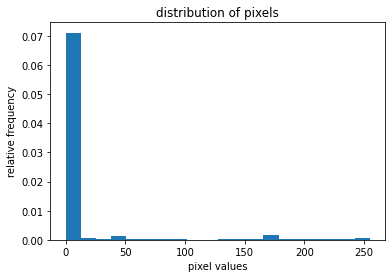

In [63]:
img_pil = train_l[1189]
plt.hist(np.array(img_pil).ravel(), bins=20,density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [64]:
def ImageTransformer(transforms: list)->None:
  Transform = torchvision.transforms.Compose(transforms)
  dl = DataLoader(CustomDataset(train_l, train_labels_l, 
                  transform=Transform), shuffle=True, batch_size=BATCH_SIZE)
  figure = plt.figure(figsize=(5,5))
  sample_idx = torch.randint(len(dl), size=(1,)).item()
  img = train_l[sample_idx]
  label = get_label_value(train_labels_l[sample_idx])
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze())

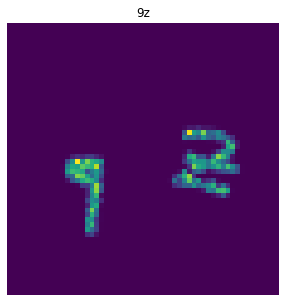

In [65]:
input = [torchvision.transforms.RandomHorizontalFlip(p=0.5)]
ex = ImageTransformer(input)

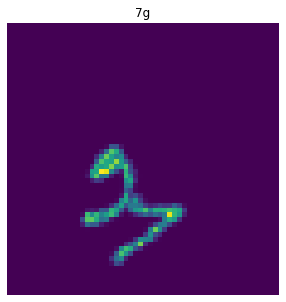

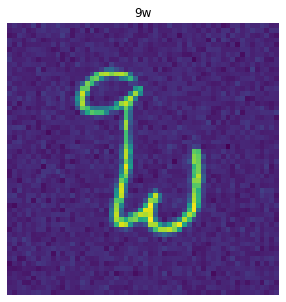

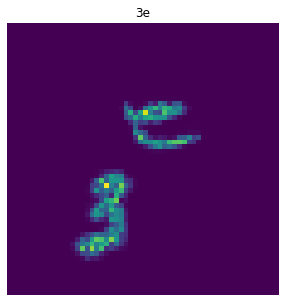

In [66]:
i = [         transforms.Normalize(mean=(0.5,), std=(0.5,)),
              torchvision.transforms.RandomResizedCrop([56,56]),
              torchvision.transforms.RandomRotation(60),
              torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3)]

for _ in range(3): ImageTransformer(i)

In [67]:
# Color, brightness shift
T1 = transforms.Compose([         transforms.Normalize(mean=(0.5,), std=(0.5,)),
                                  torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3)
                                  ])
# Random rotation, padding
T2 = transforms.Compose([         transforms.Normalize(mean=(0.5,), std=(0.5,)),
                                  torchvision.transforms.RandomRotation(45),
                                  #transforms.Pad(25, padding_mode='symmetric')
                                  ])
# Random horizontal flipping
T3 = transforms.Compose([         transforms.Normalize(mean=(0.5,), std=(0.5,)),
                                  transforms.RandomHorizontalFlip(p=0.01),
                                  ])
# Randome verticle flipping
T4 = transforms.Compose([         transforms.Normalize(mean=(0.5,), std=(0.5,)),
                                  transforms.RandomVerticalFlip(p=0.01),
                                  ])
noT = transforms.Compose([         transforms.Normalize(mean=(0.5,), std=(0.5,))])

###Datasets & Dataloaders

In [68]:
# Dataloader

# Transform function
mean = (0.5,)
std = (0.5,)
transform = transforms.Compose(
    [transforms.Normalize(mean=mean, std=std)
     ])

# DataLoaders
full_train_l_dataloader = DataLoader(CustomDataset(full_train_l, full_train_labels_l, transform=None), shuffle=True, batch_size=BATCH_SIZE)
full_train_l_ul_dataloader = DataLoader(CustomDataset(full_train_l_ul, full_train_labels_l_ul, transform=None), shuffle=True, batch_size=BATCH_SIZE)
train_l_dataloader = DataLoader(CustomDataset(train_l, train_labels_l, transform=transform), shuffle=True, batch_size=BATCH_SIZE)
train_l_ul_dataloader = DataLoader(CustomDataset(train_l_ul, train_labels_l_ul, transform=None), shuffle=True, batch_size=BATCH_SIZE)
val_l_dataloader = DataLoader(CustomDataset(val_l, val_labels_l, transform=None), shuffle=False)
val_l_ul_dataloader = DataLoader(CustomDataset(val_l_ul, val_labels_l_ul, transform=None), shuffle=False)

# Raw unlabeled dataset
# train_ul_labels = np.zeros(shape=(len(train_ul), 36))
# train_ul_dataloader = DataLoader(CustomDataset(train_ul, train_ul_labels, transform=None), batch_size=BATCH_SIZE, shuffle=False)

# Test set for Kaggle
test_labels_ul = np.zeros(shape=(len(test_ul), 36))
test_ul_dataloader = DataLoader(CustomDataset(test_ul, test_labels_ul, transform=None), batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


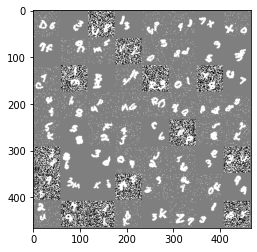

In [69]:
# Quick data visualization
imgs, labels = next(iter(full_train_l_dataloader))
imshow(torchvision.utils.make_grid(imgs.cpu()))

### Train

In [70]:
def transform_output(scores):
    """
    Input a Tensor and output will be another Tensor with same dimension but with all elements 0 except two.
    Those 2 elements will have value of 1 and will correspond to the models prediction about which letter and number
    is in the image.
    :param scores:
    :return:
    """
    return_array = []
    score_list = scores.tolist()
    for score in score_list:
        numbers = score[:10]
        letters = score[10:]
        test = lambda x, max_value : 1 if x >= max_value else 0
        new_numbers = [test(x, max(numbers)) for x in numbers]
        new_letters = [test(x, max(letters)) for x in letters]
        return_array.append(new_numbers + new_letters)
    return return_array

In [71]:
# Evaluation function
def evaluate_model(model, dl):
    accs = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(dl):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs_to_preds(outputs.cpu().detach().numpy())
            accs.append(compute_accuracy(preds, labels.cpu()))
            break
    return sum(accs)/len(accs)

In [72]:
# Train function
def train(model, dataloader=train_l_dataloader, init_rounds=2):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        
        # Using unlabeled data
        # if epoch >= init_rounds:
        #     for idx, data_ul in enumerate(train_ul_dataloader):
        #         # get data/targets
        #         inputs_ul, targets_ul = data_ul
        #         inputs_ul = inputs_ul.to(device)
        #         outputs = model(inputs_ul)
        #         fake_targets = torch.Tensor(outputs_to_predictions(outputs.cpu().detach().numpy())).to(device) # using pseudo label methods and get pseudo labels
        #         # print(fake_targets[0])
        #         optimizer.zero_grad()
        #         outputs = model(inputs_ul)
        #         loss = criterion(outputs, fake_targets)
        #         loss.backward()
        #         # optimizer.step()

        for i, data in enumerate(dataloader):
            # get data/targets
            inputs, true_targets = data
            inputs = inputs.to(device)
            true_targets = true_targets.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward, backward,
            outputs = model(inputs)
            loss = criterion(outputs, true_targets)
            # backward
            loss.backward()
            # gradient descent step
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            
            acc = evaluate_model(model, dataloader)
            if i % 100 == 99:    # print every 2000 mini-batches
                print('Epoch %d - Loss: %.4f | Accuracy: %.4f'%(epoch+1, running_loss/i, acc))
                running_loss = 0.0
    
    # DONE TRAINING
    print('Finished Training')
    PATH = './cnn.pth'
    torch.save(model.state_dict(), PATH)

### Main

In [73]:
# Run model and evaluate
cnn_model = AlexNet_CNN().to(device)
if USE_UL:
    trainloader = full_train_l_ul_dataloader if PRODUCTION else train_l_ul_dataloader
else: # use only the original labelled training set
    trainloader = full_train_l_dataloader if PRODUCTION else train_l_dataloader
train(cnn_model, trainloader)
if not PRODUCTION:
    evaluate_model(cnn_model, val_l_dataloader)

Epoch 1 - Loss: 0.2497 | Accuracy: 0.0000
Epoch 1 - Loss: 0.1048 | Accuracy: 0.0000
Epoch 1 - Loss: 0.0691 | Accuracy: 0.0000
Epoch 1 - Loss: 0.0497 | Accuracy: 0.0000
Epoch 1 - Loss: 0.0372 | Accuracy: 0.0312
Epoch 1 - Loss: 0.0284 | Accuracy: 0.0781
Epoch 1 - Loss: 0.0218 | Accuracy: 0.1562
Epoch 2 - Loss: 0.1242 | Accuracy: 0.2500
Epoch 2 - Loss: 0.0467 | Accuracy: 0.6406
Epoch 2 - Loss: 0.0248 | Accuracy: 0.7031
Epoch 2 - Loss: 0.0148 | Accuracy: 0.7031
Epoch 2 - Loss: 0.0098 | Accuracy: 0.8125
Epoch 2 - Loss: 0.0072 | Accuracy: 0.7812
Epoch 2 - Loss: 0.0058 | Accuracy: 0.8125
Epoch 3 - Loss: 0.0351 | Accuracy: 0.8594
Epoch 3 - Loss: 0.0134 | Accuracy: 0.8750
Epoch 3 - Loss: 0.0080 | Accuracy: 0.8750
Epoch 3 - Loss: 0.0059 | Accuracy: 0.9062
Epoch 3 - Loss: 0.0046 | Accuracy: 0.9219
Epoch 3 - Loss: 0.0034 | Accuracy: 0.9219
Epoch 3 - Loss: 0.0030 | Accuracy: 0.8281
Epoch 4 - Loss: 0.0197 | Accuracy: 0.9219
Epoch 4 - Loss: 0.0070 | Accuracy: 0.9375
Epoch 4 - Loss: 0.0045 | Accuracy:

In [74]:
if LABELLING:
    # Label the unlabelled dataset
    with torch.no_grad():
        predictions_ul = []
        for data in train_ul_dataloader:
            inputs = data[0].to(device)
            targets = data[1].to(device)
            outputs = cnn_model(inputs)
            converted_output = outputs_to_predictions(outputs.cpu().detach().numpy())
            for c in converted_output:
                predictions_ul.append(c)

    print(len(predictions_ul))
    predictions_ul = np.array(predictions_ul)
    print(type(predictions_ul))

    with open('labels_ul.pkl', 'wb') as train_labels_ul_pkl:
        pickle.dump(predictions_ul, train_labels_ul_pkl)

####Export predictions

In [75]:
# Setup CSV for predictions export
if PRODUCTION:
    df = pd.DataFrame(columns=['# Id', 'Category'])
    with torch.no_grad():
        i = 0
        for data in test_ul_dataloader:
            inputs = data[0].to(device)
            targets = data[1].to(device)
            outputs = cnn_model(inputs) # apply CNN model
            predictions = transform_output(outputs)
            for pred in predictions:
                label = ''.join(str(x) for x in pred)
                df.loc[i] = [i, label]
                i += 1
    print(df)

        # Id                              Category
0          0  100000000000000000000000000001000000
1          1  000010000000000000000100000000000000
2          2  000000000100000000010000000000000000
3          3  100000000000000000000100000000000000
4          4  000000100000000000010000000000000000
...      ...                                   ...
14995  14995  000100000000001000000000000000000000
14996  14996  000100000010000000000000000000000000
14997  14997  000000100000000000000000001000000000
14998  14998  010000000000000000100000000000000000
14999  14999  001000000000000000001000000000000000

[15000 rows x 2 columns]


In [76]:
# Export CSV for Kaggle
from datetime import datetime
if PRODUCTION:
    filename = 'kaggle_g19_{}.csv'.format(datetime.now())
    df.to_csv(filename, sep=',', float_format='{:36}', index=False)